In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats

In [8]:
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error , mean_absolute_error,r2_score,accuracy_score,precision_score,recall_score,f1_score , confusion_matrix

In [10]:
df = pd.read_csv(r"C:\Users\91830\Downloads\PRSA_data_2010.1.1-2014.12.31.csv")

In [12]:
print("Overview of Dataset")
df.info()

Overview of Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [14]:
print("First 5 rows of dataset")
df.head()

First 5 rows of dataset


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


**Missing values and duplicates**

In [17]:
print("Missing values:")
df.isnull().sum()

Missing values:


No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [19]:
df.dropna(inplace=True)

In [21]:
print("Missing values:")
df.isnull().sum()

Missing values:


No       0
year     0
month    0
day      0
hour     0
pm2.5    0
DEWP     0
TEMP     0
PRES     0
cbwd     0
Iws      0
Is       0
Ir       0
dtype: int64

In [23]:
duplicate_rows = df.duplicated().sum()
duplicate_rows

0

In [25]:
if{'year','month','day','hour'}.issubset(df.columns):
    df['datetime']=pd.to_datetime(df[['year','month','day','hour']])
    df.drop(columns=['year','month','day','hour'],inplace=True)
    df.set_index('datetime',inplace=True)

In [27]:
df.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
datetime,,,,,,,,,
2010-01-02 00:00:00,25,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,26,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,27,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,28,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,29,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [29]:
df.describe()

,No,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000
mean,22279.380104,98.613215,1.750174,12.401561,1016.442896,23.866747,0.055344,0.194866
std,12658.168415,92.050387,14.433658,12.175215,10.300733,49.617495,0.778875,1.418165
min,25.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,11464.000000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,22435.000000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,33262.000000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,994.000000,28.000000,42.000000,1046.000000,565.490000,27.000000,36.000000


**Outliers of the data**

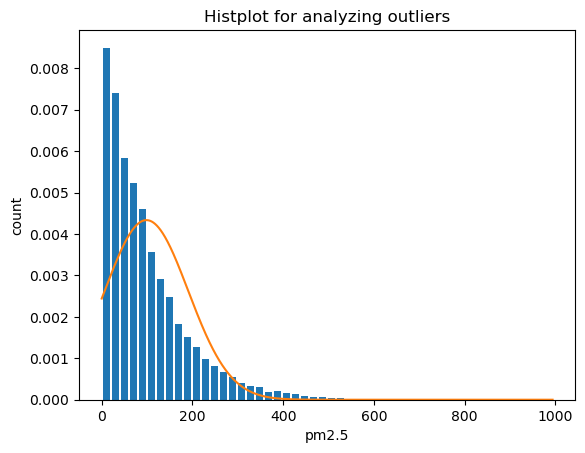

In [32]:
plt.hist(df['pm2.5'],bins=50,rwidth=0.8,density=True)
plt.xlabel('pm2.5')
plt.ylabel('count')
plt.title("Histplot for analyzing outliers")

rng = np.arange(df['pm2.5'].min(),df['pm2.5'].max(),0.1)
plt.plot(rng,norm.pdf(rng,df['pm2.5'].mean(),df['pm2.5'].std()))

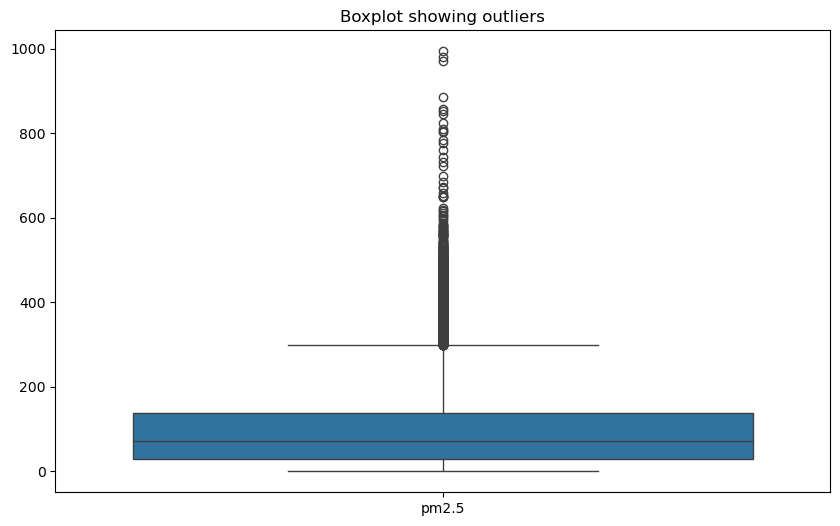

In [33]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df[['pm2.5']])
plt.title('Boxplot showing outliers')
plt.show()

**Removing Outliers using IQR**

In [36]:
Q1 = df['pm2.5'].quantile(0.25)
Q2 = df['pm2.5'].quantile(0.50)
Q3 = df['pm2.5'].quantile(0.75)
Q1,Q3

(29.0, 137.0)

In [37]:
IQR = Q3 - Q1
IQR

108.0

In [41]:
lower_limitiqr = Q1 - 1.5*IQR
upper_limitiqr = Q2 + 1.5*IQR
lower_limitiqr, upper_limitiqr

(-133.0, 234.0)

In [43]:
df[(df['pm2.5']<lower_limitiqr) | (df['pm2.5'] > upper_limitiqr)]

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
datetime,,,,,,,,,
2010-01-08 02:00:00,171,275.0,-20,-16.0,1031.0,NE,0.89,0,0
2010-01-08 13:00:00,182,250.0,-15,-8.0,1026.0,SE,4.92,0,0
2010-01-08 16:00:00,185,250.0,-16,-8.0,1025.0,cv,2.67,0,0
2010-01-14 01:00:00,314,257.0,-20,-15.0,1025.0,NE,2.67,0,0
2010-01-16 02:00:00,363,242.0,-16,-12.0,1036.0,cv,0.89,0,0
...,...,...,...,...,...,...,...,...,...
2014-12-29 00:00:00,43753,362.0,-10,-4.0,1016.0,cv,4.01,0,0
2014-12-29 01:00:00,43754,372.0,-10,-5.0,1016.0,cv,4.90,0,0
2014-12-29 02:00:00,43755,373.0,-11,-5.0,1015.0,cv,5.79,0,0


In [45]:
df_no_out=df[(df['pm2.5']>lower_limitiqr) & (df['pm2.5']<upper_limitiqr)]
df_no_out

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
datetime,,,,,,,,,
2010-01-02 00:00:00,25,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,26,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,27,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,28,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,29,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,43820,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,43821,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,43822,10.0,-22,-3.0,1034.0,NW,242.70,0,0


**Data visualization after removal of outliers**

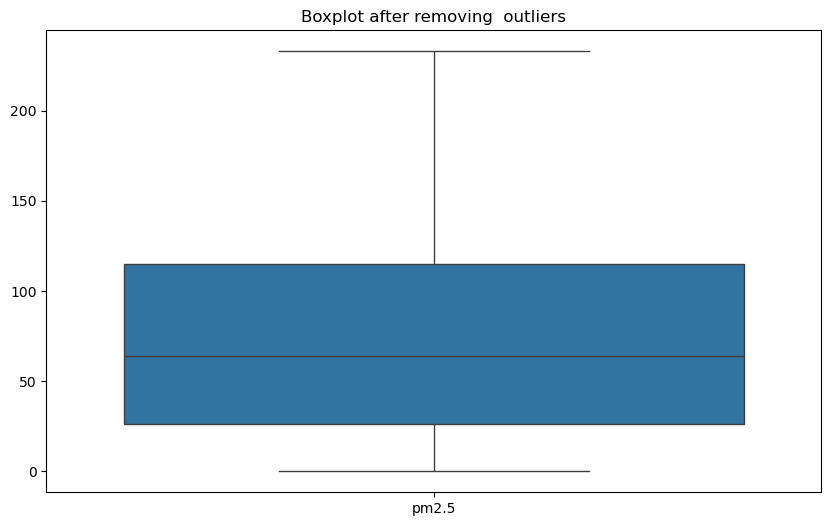

In [48]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_no_out[['pm2.5']])
plt.title('Boxplot after removing  outliers')
plt.show()

**Correlation Heatmap**

In [51]:
df_no_out = df_no_out.apply(pd.to_numeric, errors='coerce')

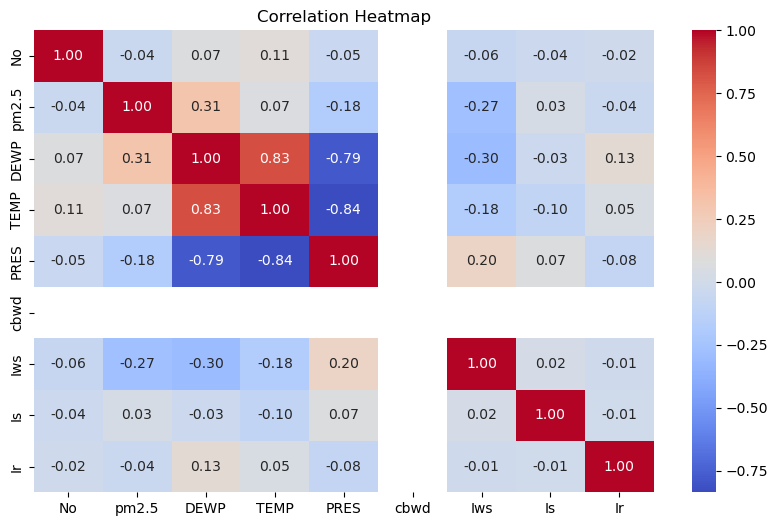

In [53]:
plt.figure(figsize=(10,6))
sns.heatmap(df_no_out.corr(),annot=True,cmap='coolwarm',fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

**MODEL BUILDING**

In [55]:
y=df['pm2.5']
X=df.drop(columns=['pm2.5'])

In [58]:
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [60]:
le = LabelEncoder()
X_train['cbwd'] = le.fit_transform(X_train['cbwd'])
X_test['cbwd'] = le.transform(X_test['cbwd'])

In [62]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test= scaler.fit_transform(X_test) 

**Linear Regression**

In [65]:
lr_model= LinearRegression()
lr_model.fit(X_train,y_train)


LinearRegression()

In [67]:
y_pred_lr_model = lr_model.predict(X_test)

In [69]:
mse_lr_model = mean_squared_error(y_test, y_pred_lr_model)
rmse_lr_model = np.sqrt(mean_squared_error(y_test, y_pred_lr_model))
mae_lr_model = mean_absolute_error(y_test, y_pred_lr_model)
r2_score_lr_model = r2_score(y_test, y_pred_lr_model)
print("MSE:",mse_lr_model)
print("RMSE:",rmse_lr_model)
print("MAE:",mae_lr_model)
print("R2_score:",r2_score_lr_model)

MSE: 6621.066336216995
RMSE: 81.36993508794876
MAE: 57.72673436939099
R2_score: 0.24858933698013708


**Random Forest Regressor**

In [72]:
rfr_model = RandomForestRegressor()
rfr_model.fit(X_train,y_train)

RandomForestRegressor()

In [73]:
y_pred_rfr_model = rfr_model.predict(X_test)

In [74]:
mse_rfr_model = mean_squared_error(y_test, y_pred_rfr_model)
rmse_rfr_model = np.sqrt(mean_squared_error(y_test, y_pred_rfr_model))
mae_rfr_model = mean_absolute_error(y_test, y_pred_rfr_model)
r2_score_rfr_model = r2_score(y_test, y_pred_rfr_model)
print("MSE:",mse_rfr_model)
print("RMSE:",rmse_rfr_model)
print("MAE:",mae_rfr_model)
print("R2_score:",r2_score_rfr_model)

MSE: 4598.496881716955
RMSE: 67.8122177908742
MAE: 42.35677322796935
R2_score: 0.4781264202285641


**Decision Tree Regressor**

In [76]:
dtr_model =DecisionTreeRegressor()
dtr_model.fit(X_train,y_train)

DecisionTreeRegressor()

In [77]:
y_pred_dtr_model = dtr_model.predict(X_test)

In [78]:
mse_dtr_model = mean_squared_error(y_test, y_pred_dtr_model)
rmse_dtr_model = np.sqrt(mean_squared_error(y_test, y_pred_dtr_model))
mae_dtr_model = mean_absolute_error(y_test, y_pred_dtr_model)
r2_score_dtr_model = r2_score(y_test, y_pred_dtr_model)
print("MSE:",mse_dtr_model)
print("RMSE:",rmse_dtr_model)
print("MAE:",mae_dtr_model)
print("R2_score:",r2_score_dtr_model)

MSE: 7312.806393678161
RMSE: 85.51494836388642
MAE: 53.1857040229885
R2_score: 0.17008523676124798


**Gradient Boosting Regressor**

In [86]:
gbr_model=GradientBoostingRegressor()
gbr_model.fit(X_train,y_train)

GradientBoostingRegressor()

In [87]:
y_pred_gbr_model = gbr_model.predict(X_test)

In [90]:
mse_gbr_model = mean_squared_error(y_test, y_pred_gbr_model)
rmse_gbr_model = np.sqrt(mean_squared_error(y_test, y_pred_gbr_model))
mae_gbr_model = mean_absolute_error(y_test, y_pred_gbr_model)
r2_score_gbr_model = r2_score(y_test, y_pred_gbr_model)
print("MSE:",mse_gbr_model)
print("RMSE:",rmse_gbr_model)
print("MAE:",mae_gbr_model)
print("R2_score:",r2_score_gbr_model)

MSE: 5384.800810212021
RMSE: 73.38120202212568
MAE: 50.408151001321976
R2_score: 0.38889046845841757


**Performance evaluation of regression models**

In [93]:
models=['Linear', 'Randomforest', 'DecisionTree','GradientBoosting']
rmse_values=[rmse_lr_model,rmse_rfr_model,rmse_dtr_model,rmse_gbr_model]
r2_values=[r2_score_lr_model,r2_score_rfr_model,r2_score_dtr_model,r2_score_gbr_model,]

Text(0, 0.5, 'RMSE')

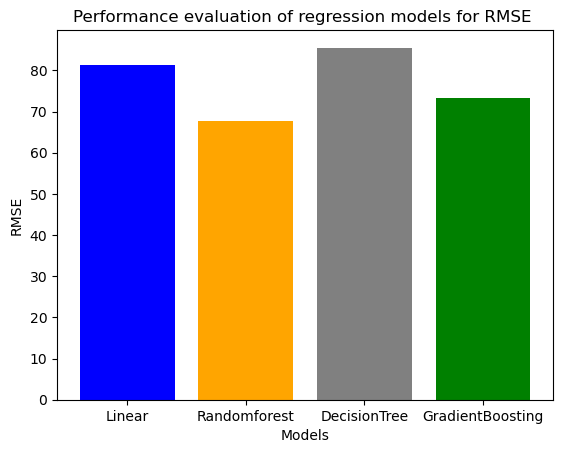

In [95]:
colors=['blue','orange','grey','green']
plt.bar(models,rmse_values,color=colors)
plt.title("Performance evaluation of regression models for RMSE ")
plt.xlabel("Models")
plt.ylabel("RMSE")

Text(0, 0.5, 'r2 score')

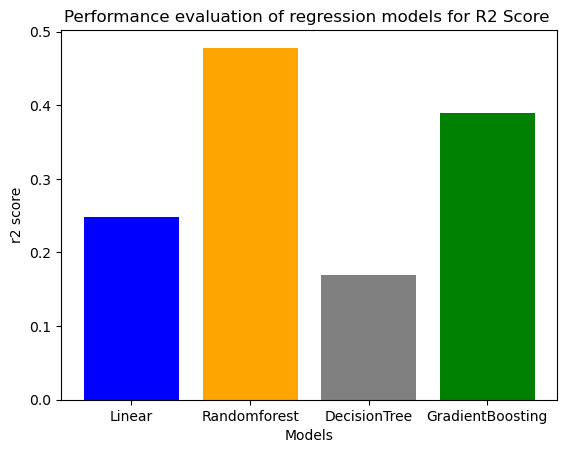

In [97]:
colors=['blue','orange','grey','green']
plt.bar(models,r2_values,color=colors)
plt.title("Performance evaluation of regression models for R2 Score ")
plt.xlabel("Models")
plt.ylabel("r2 score")

**Best model**

In [100]:
best_rmse_value = min(zip(models,rmse_values),key=lambda x: x[1])
print("The best model for RMSE value:", best_rmse_value)

The best model for RMSE value: ('Randomforest', 67.8122177908742)


In [102]:
best_r2_value = max(zip(models,r2_values),key=lambda x:x[1])
print("The best model for R2 score:",best_r2_value)

The best model for R2 score: ('Randomforest', 0.4781264202285641)
